##Mount Google Drive
This code mounts the Google Drive to the Colab environment, allowing the access of files stored on the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Import Libraries
Imports the necessary Python libraries for data manipulation (pandas, numpy), model evaluation in machine learning, and hyperparameter tuning.

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import matplotlib.pyplot as plt


##Load Dataset
Loads the dataset from a given path in Google Drive into a Pandas DataFrame.

In [ ]:
# Load dataset
file_path = '/content/drive/MyDrive/dataset/credit_risk_dataset.csv'
df = pd.read_csv(file_path)

##Data Preparation
Identifies target and feature columns, separates categorical and numerical data, and prepares the dataset for further processing.

In [ ]:
# Data preparation
target_column = 'loan_status'
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove(target_column)

X = df.drop(columns=[target_column])
y = df[target_column]

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##Preprocessing Pipelines
Creates preprocessing pipelines for numerical and categorical features using imputation and scaling strategies.


In [ ]:
# Preprocessing pipelines
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ct = ColumnTransformer([
    ('num_pipe', num_pipe, numerical_features),
    ('cat_pipe', cat_pipe, categorical_features)
])

##Model Definition
Defines multiple machine learning models, such as Logistic Regression and Random Forest, to compare their performance.

In [ ]:
# Models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}


##Model Comparison
Evaluates models with cross-validation to compare their performances.

In [ ]:
# Model comparison without tuning
results = {}
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', ct),
        ('model', model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    results[name] = np.mean(scores)
    print(f'{name}: {np.mean(scores):.4f}')


Logistic Regression: 0.8671
Random Forest: 0.9335
K-Nearest Neighbors: 0.8879
XGBoost: 0.9340
LightGBM: 0.9362


##Best Model Selection
Selects the best model based on cross-validation scores.

In [ ]:
# Best model selection
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f'Best model: {best_model_name}')



Best model: LightGBM


##Hyperparameter Tuning
Hyperparameter tuning on the models using RandomizedSearchCV.

In [ ]:
# Hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2', 'elasticnet', 'none']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200, 300, 500],
        'model__max_depth': [10, 20, 30, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'K-Nearest Neighbors': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance'],
        'model__metric': ['minkowski', 'euclidean', 'manhattan']
    },
    'XGBoost': {
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7]
    },
    'LightGBM': {
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__boosting_type': ['gbdt', 'dart', 'goss']
    }
}

##Visualizing Learning Curves
Generates learning curves for models to evaluate training and validation performance against different dataset sizes.Helps diagnose issues such as overfitting or underfitting within the models.

In [ ]:
if best_model_name in param_grids:
    pipe = Pipeline([
        ('preprocessor', ct),
        ('model', best_model)
    ])
    search = RandomizedSearchCV(pipe, param_distributions=param_grids[best_model_name], n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42, verbose=3)
    search.fit(X_train, y_train)
    print(f'Best parameters for {best_model_name}: {search.best_params_}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 5663, number of negative: 20401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 969
[LightGBM] [Info] Number of data points in the train set: 26064, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.217273 -> initscore=-1.281630
[LightGBM] [Info] Start training from score -1.281630
Best parameters for LightGBM: {'model__n_estimators': 300, 'model__learning_rate': 0.2, 'model__boosting_type': 'dart'}


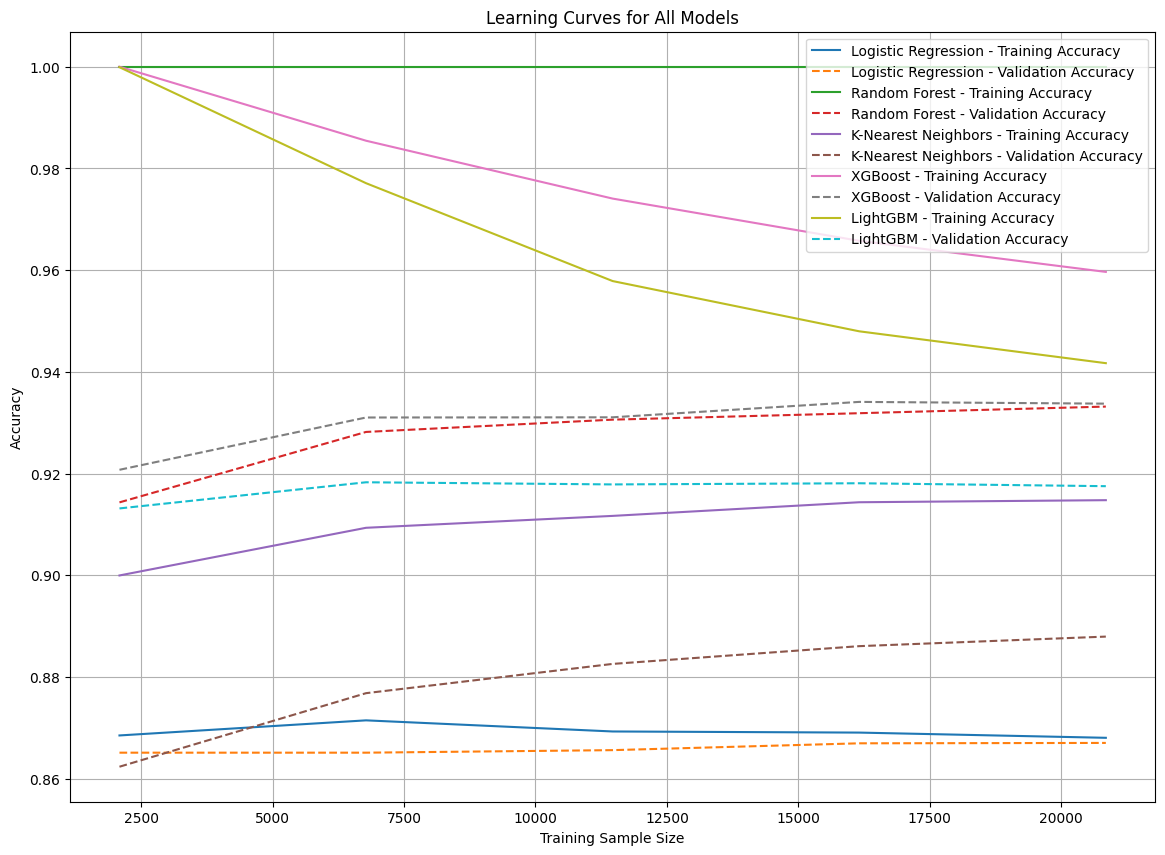

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# List of models to evaluate
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced')
}

# Plot learning curves
plt.figure(figsize=(14, 10))
for model_name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', ct),  # Use the preprocessor from earlier
        ('model', model)
    ])

    # Generate learning curves
    train_sizes, train_scores, test_scores = learning_curve(
        pipe, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
    )

    # Calculate mean scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label=f'{model_name} - Training Accuracy')
    plt.plot(train_sizes, test_scores_mean, linestyle='--', label=f'{model_name} - Validation Accuracy')

# Customize the plot
plt.title('Learning Curves for All Models')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()


##Train Final Model
Trains the best-performing model on the full training dataset and save it.

In [ ]:
best_model_name = 'Random Forest'
final_model = models[best_model_name]

final_pipe = Pipeline([
    ('preprocessor', ct),
    ('model', final_model)
])

# Training the final model on the full training data
final_pipe.fit(X_train, y_train)

# Evaluating the final model
y_pred = final_pipe.predict(X_test)
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred))

# Save the trained model with preprocessing
import joblib
joblib.dump(final_pipe, 'final_best_model.h5')
print("Trained best model saved as 'final_best_model.h5'")

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5072
           1       0.97      0.72      0.82      1445

    accuracy                           0.93      6517
   macro avg       0.95      0.85      0.89      6517
weighted avg       0.93      0.93      0.93      6517

Trained best model saved as 'final_best_model.h5'
